In [4]:
%pylab inline
import numpy as np


Populating the interactive namespace from numpy and matplotlib


### Ecuacion Difusion en Reactor Tubular

Tenemos las ecuacione que describen el intercambio de calor entre 2 fluidos en un reactor tubular, considerando despreciable el ancho del mismo, de la siguiente manera:
Dado que cr=0 cuando r=0, teneos que crr cuando r tiende a 0 es un límite de la forma 0/0. Así, usamos l'Hopital en ambas ecuaciones por lo que obtenemos que cr/r=crr para r tendiendo a 0 y con Tr=0 en r=0 entonces Trr=Trr.

Caso r 0
ct=−vcz+D(czz+2crr)−r(c,T)
ct=−vTz+λpcpD(Tzz+2Trr)−ΔHpcpr(c,T)

In [49]:
#definicion de constantes, variables y pasos de cada ecuación diferencial
n_x = 100
n_t = 20
L = 30 #esos son los valores que toca ver para un caso determinado
R = 1 # radio reservorio

r = np.linspace(0,R,n_x)
z = np.linspace(0,L,n_x)

dr = r[1]-r[0]
dz = z[1]-z[0]

#trate de hacer el dt como en la wave equation pero no veo como despejarlo, entonces lo definiremos a ojo
dt = 0.00000000000001
d_H = -525676 #entalpia
C_p = 192.59 #calor especifico
rho = 1040 #densidad
T_w = 100 #temperatura del reservorio
lamda = 200
k_0 = 10
E = 10
D = 10**-9 #difusividad
h = 200


In [50]:
#Funcion r 
def rf(c1, T1): 
    if(c1 >= 0 and T1 >= 0):
        return k_0 + np.exp(-E/(R*T1))*(c1**2)
    else:
        return 0

#Funcion v
def v_over_vmax(r1):
    return (1-(r1/R)**2)

In [90]:
#declaramos ahora las discretizaciones, inicializamos los arreglos para las soluciones encontradas
T_0 = np.ones((n_x, n_x))
c_0 = 14*np.ones((n_x, n_x))
for i in range(0,n_x):
    for j in range(0,n_x):
        T_0[i,j]=100
        c_0[i,j]=100

T_past = np.ones((n_x, n_x))
T_pres = T_0

c_past = np.ones((n_x, n_x))
c_pres = c_0

#ahora definimos las condiciones de frontera en cada caso
                        
#f es la funcion que queremos derivar, i es r, j es z. Estas son las primeras derivadas

def derivada1_r(f,i,j):
                
    if(i==len(f)): #cuando R=r
        return (h/lamda)*(Tw - f[i][j])
    elif(i == 0):
        return 0
    else:
        return (f[i+1][j]-f[i-1][j])/(2*dr) 

def derivada1_z(f,i,j):
                
    if(j==len(f)):
        return 0
    elif(j == 0):
        return 0
    else:
        return (f[i][j+1]-f[i][j-1])/(2*dz) 

#f es la funcion que queremos derivar, i es r, j es z. Estas son las segundas derivadas. 
def derivada2_r(f, i, j):
    
    if(i==len(f)):
        return (h/lamda)*(Tw - f(i,j))
    elif(i == 0):
        return 0
    return (f[i-1][j] + 2*f[i][j]-f[i][j])/(2*dr) 

def derivada2_z(f,i,j):
         
    if(j == len(f)):
        return 0
    elif(j == 0):
        return 0
    return (f[i][j+1] + 2*f[i][j]-f[i][j-1])/(2*dz)  
 
#aca no estoy segura si hacerlas por separado o en una sola funcion que derive para cada caso

In [91]:
#aca es que tengo problemas, este for recorre en t y da los cambios para c y T. 
for t in range(n_t):
    T_past = T_pres.copy()
    c_past = c_pres.copy()
    for i in range(1,n_x-1):
        for j in range(1,n_x-1): 
          
            if(r[i] == 0): #and not z[j] == L):
               
                c_pres[i,j] = dt*(c_past[i,j]) - v_over_vmax(r[i])*derivada1_z(c_past,i,j)  + D*(derivada2_z(c_past,i,j))- rf(c_past[i,j],T_past[i,j])                    
                T_pres[i,j] = dt*(T_past[i,j]) - v_over_vmax(r[i])*derivada1_z(T_past,i,j)  + (lamda/rho*C_p)*(derivada2_z(T_past,i,j))- (d_H/rho*C_p)* rf(c_past[i,j],T_past[i,j])
                
            elif(r[i] == R): #and not z[j] == L):
                               
                c_pres[i,j] = dt*(c_past[i,j]) - v_over_vmax(r[i])*derivada1_z(c_past,i,j)  + D*(derivada2_z(c_past,i,j))- rf(c_past[i,j],T_past[i,j])                    
                T_pres[i,j] = dt*(T_past[i,j]) - v_over_vmax(r[i])*derivada1_z(T_past,i,j)  + (lamda/rho*C_p)*(derivada2_z(T_past,i,j))- (d_H/rho*C_p)* rf(c_past[i,j],T_past[i,j])
                
            if(z[j] == L):
                                 
                c_pres[i,j] = 0
                T_pres[i,j] = 0
            
            else:
                c_pres[i,j] = dt*(c_past[i,j]) - v_over_vmax(r[i])*derivada1_z(c_past,i,j)  + D*(derivada2_z(c_past,i,j) + derivada2_r(c_past,i,j) + derivada1_r(c_past,i,j)/r[i])- rf(c_past[i,j],T_past[i,j])                    
                T_pres[i,j] = dt*(T_past[i,j]) - v_over_vmax(r[i])*derivada1_z(T_past,i,j)  + (lamda/rho*C_p)*(derivada2_z(T_past,i,j) + derivada2_r(T_past,i,j) + derivada1_r(T_past,i,j)/r[i])- (d_H/rho*C_p)* rf(c_past[i,j],T_past[i,j])

In [80]:
c_pres
T_pres


array([[  1.00000000e+02,   1.00000000e+02,   1.00000000e+02, ...,
          1.00000000e+02,   1.00000000e+02,   1.00000000e+02],
       [  1.00000000e+02,   1.19013252e+22,   3.43481810e+09, ...,
          3.52498108e+09,  -4.14081157e+21,   1.00000000e+02],
       [  1.00000000e+02,  -7.50519510e+24,  -1.02600583e+13, ...,
         -9.67151328e+12,   1.58128884e+26,   1.00000000e+02],
       ..., 
       [  1.00000000e+02,   1.82499523e+06,   4.31734369e-01, ...,
          4.31572426e-01,   6.40302404e+04,   1.00000000e+02],
       [  1.00000000e+02,   9.94436567e+05,   1.09750306e-01, ...,
          1.09750306e-01,   3.22819681e+04,   1.00000000e+02],
       [  1.00000000e+02,   1.00000000e+02,   1.00000000e+02, ...,
          1.00000000e+02,   1.00000000e+02,   1.00000000e+02]])

In [89]:
mini = min(T_pres)
maxi = T_pres.max()


levels = np.linspace(mini, maxi, 10000)

fig, axs = plt.subplots(1,1)
cs = axs.contourf(r, z, T_pres, levels=levels)

fig.colorbar(cs, ax=axs, format="%.3g")

plt.title('Temperatura (K)')
plt.ylabel('Z')
plt.xlabel('R')
plt.savefig('tempertura.png')

print mini, maxi

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

(-1.5285856003648062e+22, 1.2754896994938252e+20)

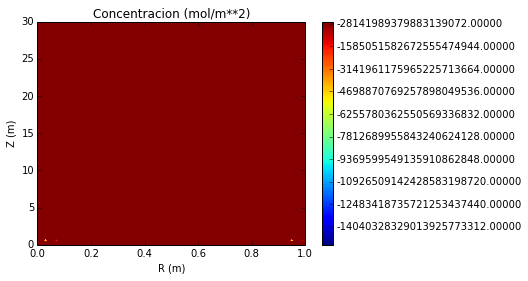

In [86]:

mini = c_pres.min()
maxi = c_pres.max()
#Se define el numero de niveles que va a tener el contorno. Para nuestro caso elegimos 100
levels = np.linspace(mini, maxi, 100)

fig, axs = plt.subplots(1,1)
#Se hace el mapeo por el contorno dado

cs = axs.contourf(r, z, c_pres, levels=levels)
#Se añade barra de color
fig.colorbar(cs, ax=axs, format="%.5f")

plt.title('Concentracion (mol/m**2)')
plt.ylabel('Z (m)')
plt.xlabel('R (m)')
plt.savefig('concentracion.png')

mini, maxi

In [ ]:
#escoger un tiempo dado y graficar la T y C haciendo variar el Z en 2D y variar el otro parametro
#O en 3D hacer un grafico de T Z C
#Los parametros pueden cambiar, esta bien pero R y L mejor dejarlos quietos

#Lambda 

#usar cobre como material del tubob y agua con flujo laminar

#las derivadas son continuas en los bordes. Condiciones tipo Dirichlet y Newmann 

#Exercise

1. Write a program in C to compute the solution of the 1D Burgers Equation.
Make a program in Python to make a movie of the time evolution. Use the same initial conditions as above. 

2. Write a program in C to compute the solution of the 2D Burguers Equation.
Make a program in Python to make a movie of the time evolution. Follow this: http://nbviewer.ipython.org/github/barbagroup/CFDPython/blob/master/lessons/10_Step_8.ipynb